# Notebook with PCA model and no conditionning

## Loading Libraries 

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images

In [2]:
#paths in git

#root git folder 
#path_main_folder = '/home/marotant/dev/Autoencoder_Embedding_Expert_Caracteristion_'
path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [3]:
#import class and methods from src
from keras import backend as K
from CVAE.callbacks import NEpochLogger,callbackWeightLoss
#from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE, CVAE_emb, CAE
from conso.load_shape_data import *  

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [4]:
#directories to store trained model and the related projector

log_dir_projector=path_main_folder+"/notebooks/logs/Expe1/PCA/projector"
log_dir_model=path_main_folder+"/notebooks/logs/Expe1/PCA/model"
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)

# Table of contents:
- Load Data
- Make Training Set
- Define and Train Model
- Build Projector
- Compute Feature Scores in latent space
- Study reconstruction Error
- Study Holidays prediction
- Detect atypical events
- Conclusion

# Load dataset 

In [5]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data')
dataset_csv = os.path.join(path_data, "dataset.csv")
x_conso = pd.read_csv(dataset_csv, sep=",",)
x_conso.ds = pd.to_datetime(x_conso.ds)

In [6]:
#drop indices column
x_conso=x_conso.drop(columns=x_conso.columns[0],axis=1)


In [7]:
#Visualize data frame head
x_conso.head(5)

,ds,consumption_France,temperature_France,is_holiday_day
0,2012-12-28 00:00:00,59679.0,8.817600,0.0
1,2012-12-28 00:30:00,58103.0,8.690875,0.0
2,2012-12-28 01:00:00,55354.0,8.564150,0.0
3,2012-12-28 01:30:00,55196.0,8.440525,0.0
4,2012-12-28 02:00:00,54324.0,8.316900,0.0


# Make training set of daily electrical consumption profiles and conditions 
In this experiment there is no condition to pass. This is not something we can do with a PCA anyway

In [8]:
name_set_plot = 'train'
version = '-v1'
nPoints=1830

In [9]:
dict_xconso = {'train': x_conso}

In [10]:
# Normalize input variables
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption_France']


In [11]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso)

(1830, 13)


/home/marotant/dev/Autoencoder_Embedding_Expert_Caracteristion_/src/conso/load_shape_data.py:212: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/marotant/dev/Autoencoder_Embedding_Expert_Caracteristion_/src/conso/load_shape_data.py:215: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/home/marotant/dev/Autoencoder_Embedding_Expert_Caracteristion_/src/conso/load_shape_data.py:328: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [12]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0

### Build and learn PCA model

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)


In [14]:
x = dataset['train']['x'][0]

In [15]:
from sklearn.model_selection import KFold # import KFold
import sklearn as sk
kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(x) # returns the number of splitting iterations in the cross-validator

for train_index, test_index in kf.split(x):
    #print('TRAIN:', train_index, 'TEST:', test_index)
    X_train, X_test = x[train_index], x[test_index]
    principalComponents = pca.fit_transform(X_train)
    X_test_pca=pca.transform(X_test)
    x_hat = pca.inverse_transform(X_test_pca)
    print("mae loss:")
    print(sk.metrics.mean_absolute_error(X_test,x_hat))
    print("mse loss:")
    print(sk.metrics.mean_squared_error(X_test,x_hat))
   # y_train, y_test = y[train_index], y[test_index]

mae loss:
0.05821370297350184
mse loss:
0.006451173903977164
mae loss:
0.05206847302069684
mse loss:
0.005249421774072467
mae loss:
0.0552022110187419
mse loss:
0.0057140304249366355
mae loss:
0.052075805501119427
mse loss:
0.005019840688465216
mae loss:
0.05310236272802382
mse loss:
0.005287721455868616


In [16]:
pca.explained_variance_ratio_

array([0.96032886, 0.02545961, 0.007744  ])

In [17]:
filename = log_dir_model+'/pca.sav'
pickle.dump(pca, open(filename, 'wb'))

In [18]:
x_encoded=pca.transform(x)
x_hat = pca.inverse_transform(x_encoded)

In [19]:
import sklearn as sk
print("mae loss:")
sk.metrics.mean_absolute_error(x,x_hat)


mae loss:


0.05375902445485037

# Analysis of the latent space with the construction of a tensorboard projector

In [20]:
includeConsumptionProfileImages=True #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
if includeConsumptionProfileImages:
    nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
    x_encoded_reduced=x_encoded[0:nPoints,]
    images=createLoadProfileImages(x,x_hat,nPoints)
else:
    nPoints=1830

<Figure size 432x288 with 0 Axes>

In [21]:
if includeConsumptionProfileImages:
    sprites=images_to_sprite(images)
    cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)

In [22]:

writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
if includeConsumptionProfileImages:
    buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
else:
    buildProjector(x_encoded,images=None, log_dir=log_dir_projector)

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
log_dir_projector

'/home/marotant/dev/Autoencoder_Embedding_Expert_Caracteristion_/notebooks/logs/Expe1/PCA/projector'

# Predict Features in latent space

In [24]:
df_noCond_PCA=predictFeaturesInLatentSPace(x_conso,calendar_info,x_encoded)

/home/marotant/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/marotant/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/marotant/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning:

Mean of empty slice.

/home/marotant/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



3.786803609375
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.958074  0.513284  0.432883        0.218182     0.884635
random model    0.490645  0.129448  0.087345        0.047273    -0.392522


# reconstruction error analysis

In [25]:
error=np.sum(np.abs((x - x_hat)),axis=1)/48

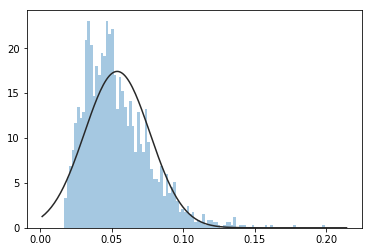

In [26]:
#make a histogram over residuals
import seaborn as sn
sn.distplot(error, kde=False, fit=stats.norm, bins=100)

Check the day with errors above a threshold

In [27]:
ErrorThreshold=0.15
idxMaxError=[i for i in range(0,nPoints) if error[i]>=ErrorThreshold]
calender_error=calendar_info.loc[idxMaxError]
calender_error['error']=error[idxMaxError]

calender_error

,ds,month,weekday,is_weekday,is_holiday_day,error
21,2013-01-18,1,4,1,0.0,0.161821
22,2013-01-19,1,5,0,0.0,0.177596
93,2013-03-31,3,6,0,0.0,0.198970
1491,2017-01-27,1,4,1,0.0,0.158330


Check the first n days with highest errors 

In [28]:
nDays=30

decreasingOrderIdx=np.argsort(-error)
calendar_Error_Highest=calendar_info.loc[decreasingOrderIdx[0:nDays]]
calendar_Error_Highest['error']=error[decreasingOrderIdx[0:nDays]]
calendar_Error_Highest

,ds,month,weekday,is_weekday,is_holiday_day,error
93,2013-03-31,3,6,0,0.0,0.198970
22,2013-01-19,1,5,0,0.0,0.177596
21,2013-01-18,1,4,1,0.0,0.161821
1491,2017-01-27,1,4,1,0.0,0.158330
1471,2017-01-07,1,5,0,0.0,0.149599
1774,2017-11-06,11,0,1,0.0,0.142441
1431,2016-11-28,11,0,1,0.0,0.141785
57,2013-02-23,2,5,0,0.0,0.138886
1767,2017-10-30,10,0,1,0.0,0.136232
1827,2017-12-29,12,4,1,0.0,0.135802


Visualize the reconstruction error over a specific day

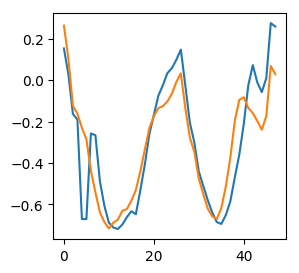

In [29]:
indice=1185 #1185 is the changing hour day end of march
fig = plt.figure(dpi=100,figsize=(3,3))
#set(gca,'Color','k')
plt.plot(x[indice,:])
plt.plot(x_hat[indice,:])

Visualize the reconstruction error over the days with highest error

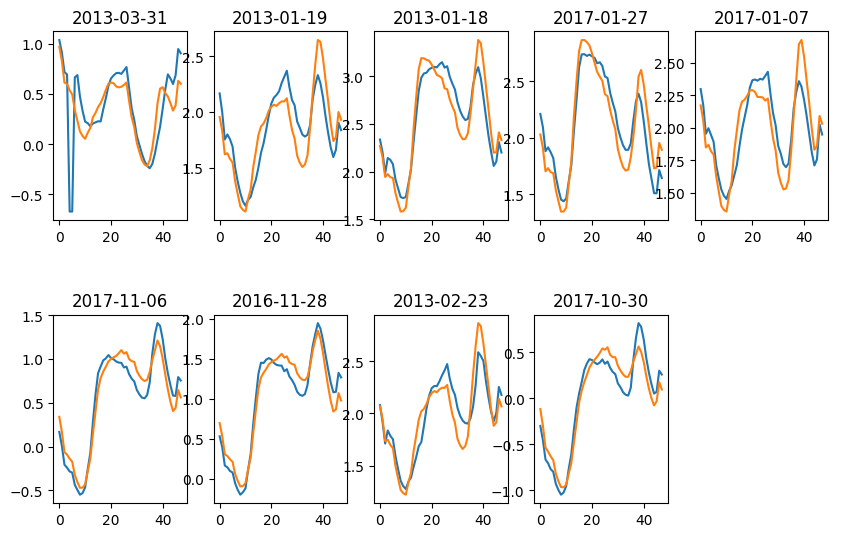

In [30]:
nPlots=10#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,2*nRows))
for i in range(1, nPlots):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=decreasingOrderIdx[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_Error_Highest.ds.dt.date.iloc[i-1])

2013-03-31 is the day with a missing hour because of changing day time and the consumption value is set to 0. It is hence normal that it is not well predicted and a good indicator that the model does not tend to overfit.

# Study of holiday predictions

In [31]:
#preparation des features d'interet
yHd=calendar_info['is_holiday_day'].astype(int)
indicesHd=np.array([i for i in range(0, nPoints) if yHd[i] == 1])
yHd_only=yHd[yHd==1]
x_encoded_Hd=x_encoded[indicesHd,]

In [32]:
results_hd=scoreKnnResults(x_encoded,yHd,type='classifier',k=5,cv=10)



/home/marotant/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/marotant/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



## holidays well predicted

In [33]:
results_hd_only=[results_hd['predP'][i] for i in indicesHd ]
indices_Hd_predict=[i for i in indicesHd if  results_hd['predP'][i]>=0.5]
indices_Hd_not_predicted=[i for i in indicesHd if  results_hd['predP'][i]<0.5]
calendar_info.loc[indices_Hd_predict]

,ds,month,weekday,is_weekday,is_holiday_day
4,2013-01-01,1,1,1,1.0
132,2013-05-09,5,3,1,1.0
673,2014-11-01,11,5,0,1.0
727,2014-12-25,12,3,1,1.0
854,2015-05-01,5,4,1,1.0
1458,2016-12-25,12,6,0,1.0


In [34]:
yWeekday=calendar_info['is_weekday']
results_wk=scoreKnnResults(x_encoded,yWeekday,type='classifier',k=10,cv=10)



In [35]:
weekdays_predicted_as_weekend=[i for i in range(0,1830) if  results_wk['predP'][i]<=0.5 and yWeekday[i]==1]
calendar_info.loc[weekdays_predicted_as_weekend]

,ds,month,weekday,is_weekday,is_holiday_day
3,2012-12-31,12,0,1,0.0
4,2013-01-01,1,1,1,1.0
94,2013-04-01,4,0,1,1.0
124,2013-05-01,5,2,1,1.0
131,2013-05-08,5,2,1,1.0
132,2013-05-09,5,3,1,1.0
143,2013-05-20,5,0,1,1.0
230,2013-08-15,8,3,1,1.0
308,2013-11-01,11,4,1,1.0
318,2013-11-11,11,0,1,1.0


In [36]:
len(weekdays_predicted_as_weekend)

55

We find out that holidays actually look alike weekends even if they are happening during weekdays

# Holidays & nearest neighbors

<function matplotlib.pyplot.show(*args, **kw)>

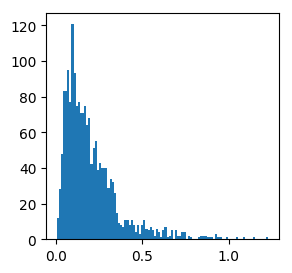

In [37]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(10)
neigh.fit(x_encoded)

[distance_knn,kneighbors]=neigh.kneighbors(x_encoded, 2, return_distance=True)
nearest=distance_knn[:,1]
fig = plt.figure(dpi=100,figsize=(3,3))
plt.hist(nearest,bins=100)
plt.show

In [38]:
from scipy import stats

stats.describe(nearest)

DescribeResult(nobs=1830, minmax=(0.006205709370490723, 1.2283600817527203), mean=0.20296118122876952, variance=0.02558086615384549, skewness=2.0270735300130847, kurtosis=5.670478655631507)

<function matplotlib.pyplot.show(*args, **kw)>

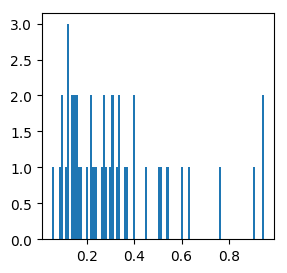

In [39]:
fig = plt.figure(dpi=100,figsize=(3,3))
plt.hist(nearest[indicesHd],bins=100)
plt.show

In [40]:
stats.describe(nearest[indicesHd])

DescribeResult(nobs=45, minmax=(0.05245008290501146, 0.9474055122680435), mean=0.32131168942855093, variance=0.05318022838350501, skewness=1.344481728428297, kurtosis=1.1716969125117895)

In [41]:
calendar_info.loc[np.where(nearest>=1)]

,ds,month,weekday,is_weekday,is_holiday_day
22,2013-01-19,1,5,0,0.0
65,2013-03-03,3,6,0,0.0
703,2014-12-01,12,0,1,0.0
1485,2017-01-21,1,5,0,0.0


2013-01-19 and 2017-01-21 were big snowy events in France. 2013-03-03 and 2014-12-01 are harder to interpret

In [42]:
indicesNear=[i for i in range(0,len(nearest)) if nearest[i]>=1]
nearest[np.where(nearest>=1)]

array([1.04559442, 1.08668845, 1.22836008, 1.1454994 ])

<bound method Figure.show of <Figure size 1000x300 with 4 Axes>>

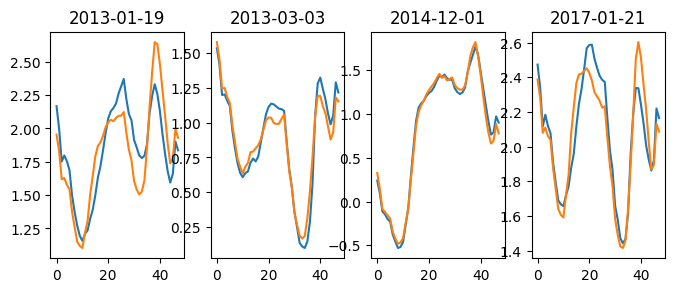

In [43]:
nPlots=len(indicesNear)#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,3))
for i in range(1, nPlots+1):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=indicesNear[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_info.ds.dt.date.iloc[indice])
fig.show

# Conclusions
- 3 dimensions covers most of the information for the variety of daily load curves 
- We recovered with this simple linear model the two main features that caracterizes electrical consumption: weekday and temperature
- Holidays are not yet well predicted and represented, although we know they are an important atypical factor.
- We however detect that holidays all look alike weekend days
- We discover some first interpretable events.

